In [2]:
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

# Load data
url = "https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv"
data = pd.read_csv(url, low_memory=False)

# Encode dependent variable (ordinal)
data['WELLNESS_life_satisfaction'] = data['WELLNESS_life_satisfaction'].astype('category').cat.codes

# Encode categorical independent variables
data['CONNECTION_social_num_close_friends_grouped'] = data['CONNECTION_social_num_close_friends_grouped'].astype('category').cat.codes
data['CONNECTION_activities_church_p3m'] = data['CONNECTION_activities_church_p3m'].astype('category').cat.codes

# Remove rows where 'CONNECTION_social_num_close_friends_grouped' is -1 or 10
data_clean = data[~data['CONNECTION_social_num_close_friends_grouped'].isin([-1, 10])]

print(data[['WELLNESS_life_satisfaction', 
            'WELLNESS_anxiety_diagnosis', 
            'CONNECTION_social_num_close_friends_grouped', 
            'CONNECTION_activities_church_p3m', 
            'CONNECTION_activities_walk_p3m']].dtypes)

# Drop rows with NaN in these columns
data = data.dropna(subset=["WELLNESS_life_satisfaction","CONNECTION_social_num_close_friends_grouped","CONNECTION_activities_church_p3m"])

# Define dependent and independent variables
y = data['WELLNESS_life_satisfaction']
X = data[['CONNECTION_social_num_close_friends_grouped', 
          'CONNECTION_activities_church_p3m', 
          ]]

# Fit ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# View results
print(result.summary())

WELLNESS_life_satisfaction                       int8
WELLNESS_anxiety_diagnosis                     object
CONNECTION_social_num_close_friends_grouped      int8
CONNECTION_activities_church_p3m                 int8
CONNECTION_activities_walk_p3m                 object
dtype: object
Optimization terminated successfully.
         Current function value: 2.161249
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
                                 OrderedModel Results                                 
Dep. Variable:     WELLNESS_life_satisfaction   Log-Likelihood:                -24705.
Model:                           OrderedModel   AIC:                         4.943e+04
Method:                    Maximum Likelihood   BIC:                         4.952e+04
Date:                        Fri, 29 Nov 2024                                         
Time:                                20:21:57                                         
No. Observations:     

/tmp/ipykernel_52/1709620003.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.values, y=coefficients.index, palette='viridis')


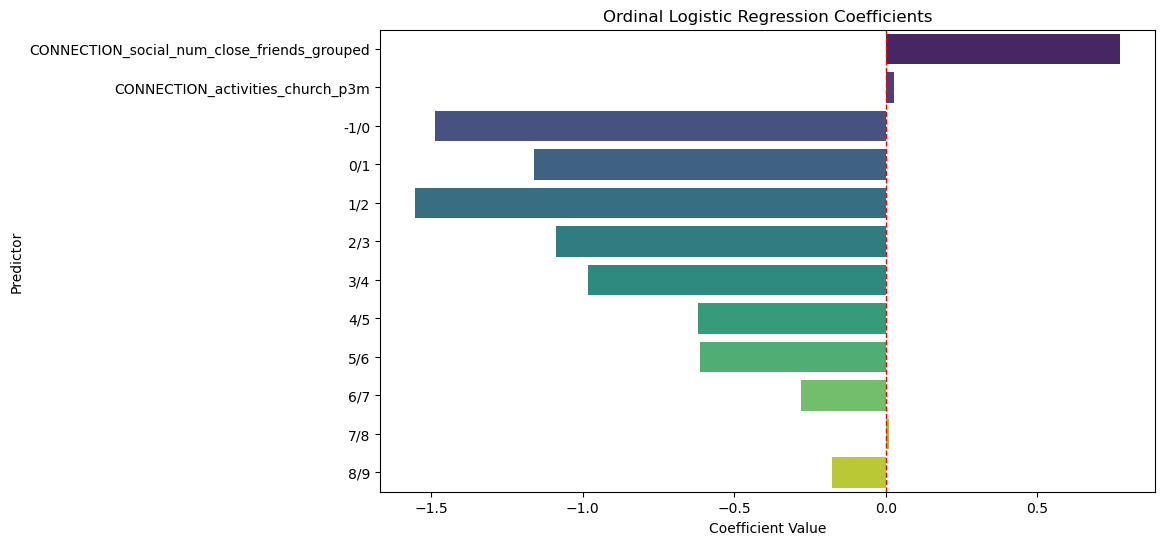

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract coefficients
coefficients = result.params
coefficients = coefficients[~coefficients.index.str.contains('cut')]  # Exclude thresholds

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.values, y=coefficients.index, palette='viridis')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title('Ordinal Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.show()


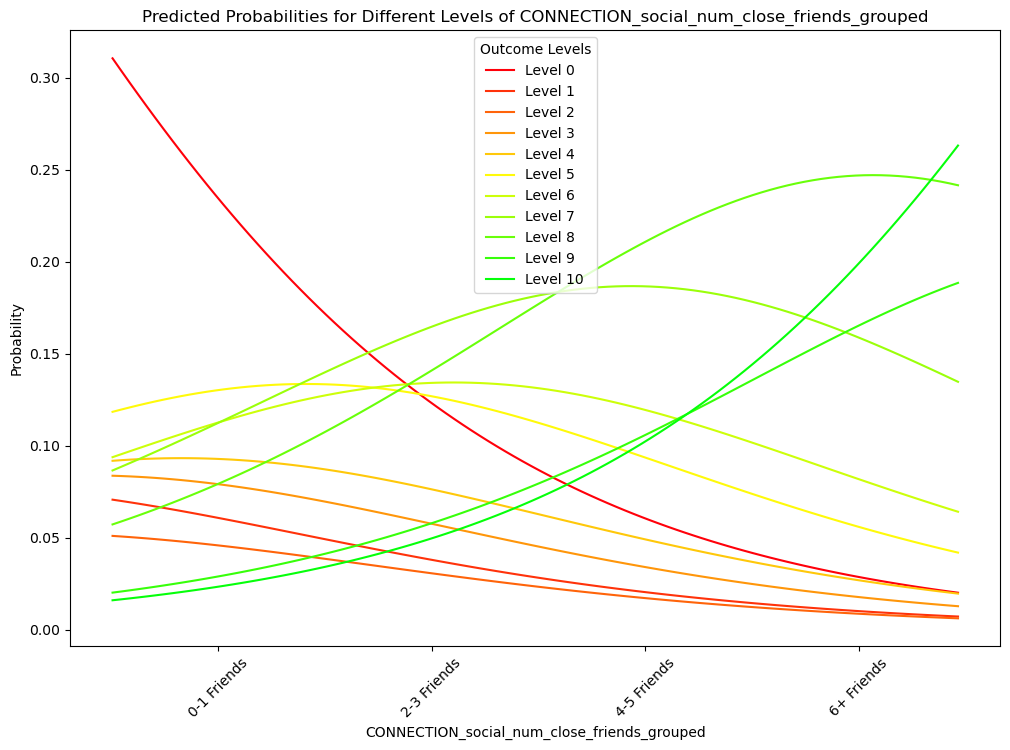

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get the median values of all predictors
X_medians = X.median(axis=0).to_frame().T

# Define the predictor to vary
predictor = 'CONNECTION_social_num_close_friends_grouped'

# Define the mapping from numeric values to category labels
category_mapping = {
    0: '0-1 Friends',
    1: '2-3 Friends',
    2: '4-5 Friends',
    3: '6+ Friends'
}

# Repeat the median values for all points along the range of the predictor
values = np.linspace(data[predictor].min(), data[predictor].max(), 100)
X_new = pd.concat([X_medians] * len(values), ignore_index=True)

# Replace the column for the predictor with its varying values
X_new[predictor] = values

# Predict probabilities for each level
predicted_probs = result.predict(X_new)

# Map the continuous values back to the closest categorical level using the mapping
category_labels = [category_mapping.get(int(val), 'Unknown') for val in values]

# Plot
plt.figure(figsize=(12, 8))
for i, level in enumerate(predicted_probs.columns):
    if i <= 5:
        plt.plot(values, predicted_probs[level], label=f'Level {i}', color=(1,(50*i)/255,10/255))
    if i > 5:
        plt.plot(values, predicted_probs[level], label=f'Level {i}', color=(((255-50*(i-5))/255),1,10/255))


# Get the positions of the x-ticks corresponding to each unique category
unique_positions = np.linspace(values.min()+.5, values.max()+.5, len(category_labels))

# Update the x-axis to show only one label per category (e.g., use the first occurrence of each category)
plt.xticks(ticks=unique_positions[::len(unique_positions)//len(category_mapping)], 
           labels=[category_mapping[i] for i in range(len(category_mapping))])

# Set plot title and labels
plt.title(f'Predicted Probabilities for Different Levels of {predictor}')
plt.xlabel(predictor)
plt.ylabel('Probability')
plt.legend(title='Outcome Levels')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


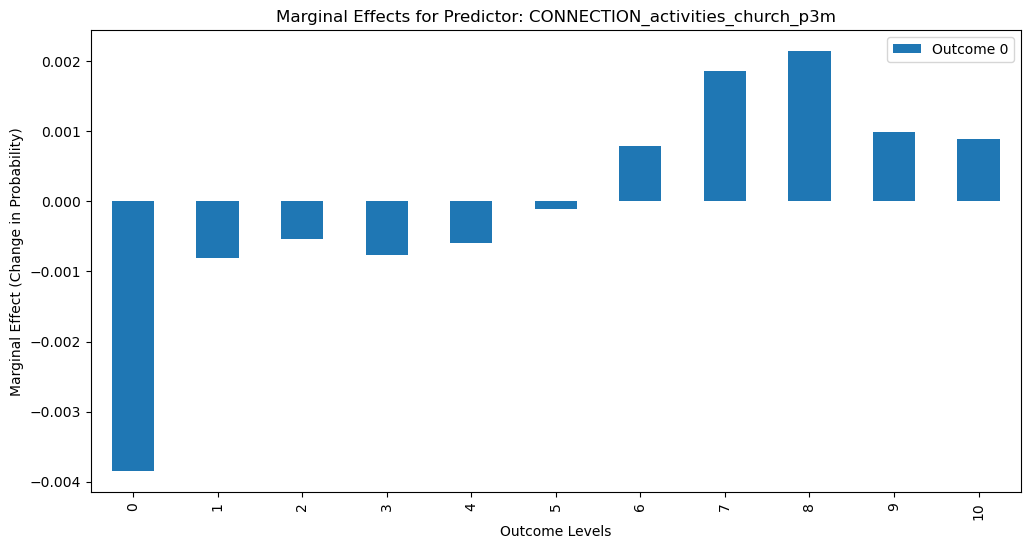

In [57]:
# Define a small change (delta) for the predictor
delta = 1e-4

# Select a predictor to calculate marginal effects
predictor = 'CONNECTION_activities_church_p3m'

# Get median values for all predictors
X_medians = X.median(axis=0).to_frame().T

# Predict probabilities at median values
baseline_probs = result.predict(X_medians)

# Perturb the predictor slightly
X_medians_plus = X_medians.copy()
X_medians_plus[predictor] += delta

# Predict probabilities with the perturbed predictor
perturbed_probs = result.predict(X_medians_plus)

# Calculate marginal effects (approximation using finite differences)
marginal_effects = (perturbed_probs - baseline_probs) / delta

# Convert to a DataFrame for better visualization
marginal_effects_df = marginal_effects.T
marginal_effects_df.columns = [f'Outcome {i}' for i in range(marginal_effects_df.shape[1])]

# Plot marginal effects
marginal_effects_df.plot(kind='bar', figsize=(12, 6), legend=True)
plt.title(f'Marginal Effects for Predictor: {predictor}')
plt.ylabel('Marginal Effect (Change in Probability)')
plt.xlabel('Outcome Levels')
plt.show()


   -1         0         1         2         3         4         5         6   \
0  NaN -0.334062  0.927100 -0.051906 -0.083926 -0.090346 -0.113946 -0.088244   
1  NaN -0.047214 -0.016271 -0.013807 -0.027674 -0.040687 -0.080232  0.892062   
2  NaN -0.047214 -0.016271 -0.013807 -0.027674  0.959313 -0.080232 -0.107938   
3  NaN -0.038399 -0.013398 -0.011437  0.976888 -0.034444 -0.069588 -0.097276   
4  NaN -0.038399 -0.013398 -0.011437 -0.023112 -0.034444 -0.069588 -0.097276   

         7         8         9    10  
0 -0.079933 -0.052084 -0.018228  NaN  
1 -0.182379 -0.229118 -0.125638  NaN  
2 -0.182379 -0.229118 -0.125638  NaN  
3 -0.174660 -0.239917 -0.142465  NaN  
4  0.825340 -0.239917 -0.142465  NaN  
   -1         0         1         2         3         4         5         6   \
0  NaN -0.334062  0.593037  0.541131  0.457205  0.366859  0.252913  0.164669   
1  NaN -0.047214 -0.063484 -0.077291 -0.104965 -0.145651 -0.225883  0.666178   
2  NaN -0.047214 -0.063484 -0.077291 -0.10496

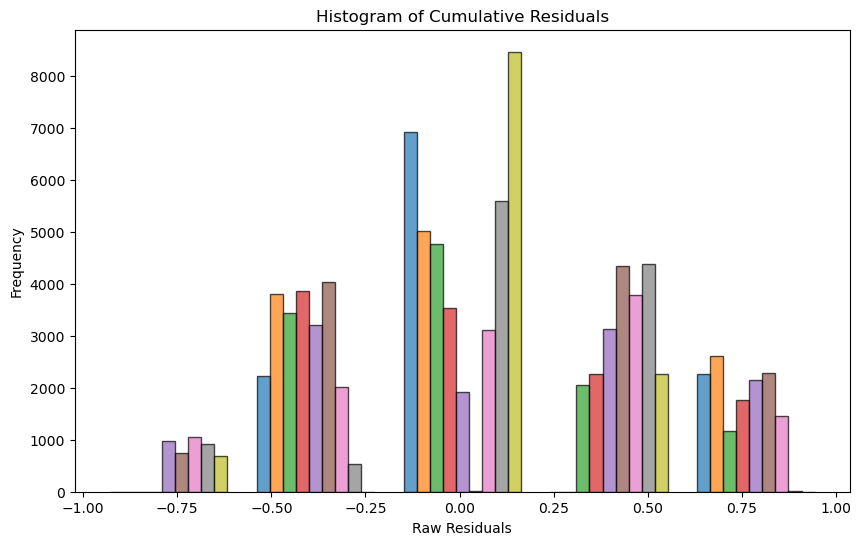

In [4]:
# Get predicted probabilities for each outcome
predicted_probs = result.predict(X)

# Convert observed outcomes (y) to one-hot encoding
observed_outcomes = pd.get_dummies(y)

# Compute raw residuals: observed - predicted for each category
raw_residuals = observed_outcomes - predicted_probs

# View the residuals for the first few observations
print(raw_residuals.head())

# Calculate cumulative probabilities for observed and predicted outcomes
observed_cumulative_probs = observed_outcomes.cumsum(axis=1)
predicted_cumulative_probs = predicted_probs.cumsum(axis=1)

# Compute cumulative residuals
cumulative_residuals = observed_cumulative_probs - predicted_cumulative_probs

# View the cumulative residuals for the first few observations
print(cumulative_residuals.head())

import matplotlib.pyplot as plt
from scipy import stats

# Calculate cumulative residuals
observed_cumulative_probs = observed_outcomes.cumsum(axis=1)
predicted_cumulative_probs = predicted_probs.cumsum(axis=1)

# Compute cumulative residuals
cumulative_residuals = observed_cumulative_probs - predicted_cumulative_probs

# Plot histogram of raw residuals for better distribution visualization
plt.figure(figsize=(10, 6))
plt.hist(cumulative_residuals.iloc[:, 1:10], bins=5, edgecolor='k', alpha=0.7)
#plt.axvline(0, color='red', linestyle='--')
# Plot the normal distribution curve
plt.title('Histogram of Cumulative Residuals')
plt.xlabel('Raw Residuals')
plt.ylabel('Frequency')
plt.show()





